import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

#sys.path.append('/home/skong2/project/dpff4ldl')
#from utils.metrics import *
#from utils.flow_functions import *
#from models.pem import *
#from models.PEM_compact import *
#from fetchData.datasetCOMBINED import *
#from trainingProtocol.trainval_COM2s_intFlow_LazyPrior_bidirection import *
#from trainingProtocol.trainval_COM2s_intFlow_sLazyPrior_bidirectionAllLayers import *
#from losses import *
#from losses_suppl import *

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch import *
from utils.trainval_detSegVoting import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
# Here define the path, which is used to save the log and trained model in training process

project_name = 'step002_det_P001_segVoting_v1' 

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:1'
print(device)

freqShow = 20
weight_reg = 2.0
weight_background = 0.1

#model parameters
batch_size = 4
newSize = [512, 512]
total_epoch_num = 500  # total number of epoch in training
base_lr = 0.0005      # base learning rate/
scaleList = [0]      # the number of output layer for U-net
#scale = [0,1,2,3]      # the number of output layer for U-net


exp_dir = './exp' # experiment directory, used for reading the init model
save_dir = os.path.join(exp_dir, project_name) # where to save the log file and trained models.
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)
log_filename = os.path.join(save_dir, 'train.log')

cuda:1


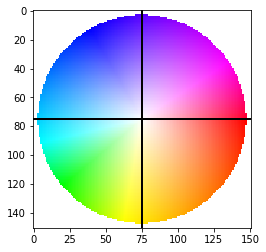

In [3]:
objDemoShowFlow = DemoShowFlow() # height=int(Y.max()), width=int(Y.max())
plt.imshow(objDemoShowFlow.FlowColorChart)
#plt.imshow(objDemoShowFlow.FlowColorChartNoAxes)
#misc.imsave(os.path.join(save_dir, 'colorchar.png'.format(idx)), objDemoShowFlow.FlowColorChart*255, format='png')

In [4]:
path_to_image = '/home/skong2/restore/dataset/pollenProject_dataset_part1'
path_to_annotCombo = '/home/skong2/restore/dataset/pollenProject_dataset_annotationCombo'
with open('dbinfo.plk', 'rb') as handle:
    dbinfo = pickle.load(handle)    
#dbinfo.keys(), len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

det_datasets = {set_name: PollenDet(path_to_image=path_to_image,
                                    path_to_annot=path_to_annotCombo,
                                    dbinfo=dbinfo,
                                    size=newSize, 
                                    set_name=set_name)
                for set_name in ['train', 'test']}


dataloaders = {set_name: DataLoader(det_datasets[set_name],                                    
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'test']}

print(len(det_datasets['train']), len(det_datasets['test']))

4997 1218


In [5]:
################## init model ###################
path_to_save_paramOnly = path.join('./exp', project_name, 'bestValModel_encoder.paramOnly')

curmodel = PollenDet_SegVoting(34, scaleList=scaleList, pretrained=True)




curmodel.load_state_dict(torch.load(path_to_save_paramOnly, map_location='cpu'))
#curmodel.load_state_dict(torch.load(path_to_save_paramOnly), map_location='cpu')

curmodel.to(device);    
#print(curmodel.state_dict)
curmodel.eval()
#curmodel.train()
curmodel.training = False
print(curmodel.training)

using pretrained model
False


In [6]:
iterCount, sampleCount = 0, 0
phase = 'test'
for sample in dataloaders[phase]: 
            
    image, grndSeg, grndDistTransform, mask_overlap, mask_voteX, mask_voteY, mask_peaks, mask_radius = sample
    
    image = image.to(device)
    grndSeg = grndSeg.to(device) 
    mask_voteX = mask_voteX.to(device)
    mask_voteY = mask_voteY.to(device)
    mask_overlap = mask_overlap.to(device)
    
    iterCount += 1
    sampleCount += grndSeg.size(0)   
    
    outputs = curmodel(image)
    predSeg = outputs[('segMask', 0)]
    predYXOffset = outputs[('output', 0)]
    
    if iterCount == 1:
        break

In [7]:
image.shape, predSeg.shape

(torch.Size([4, 3, 512, 512]), torch.Size([4, 1, 512, 512]))

Text(0.5, 1.0, 'offset to center - pred')

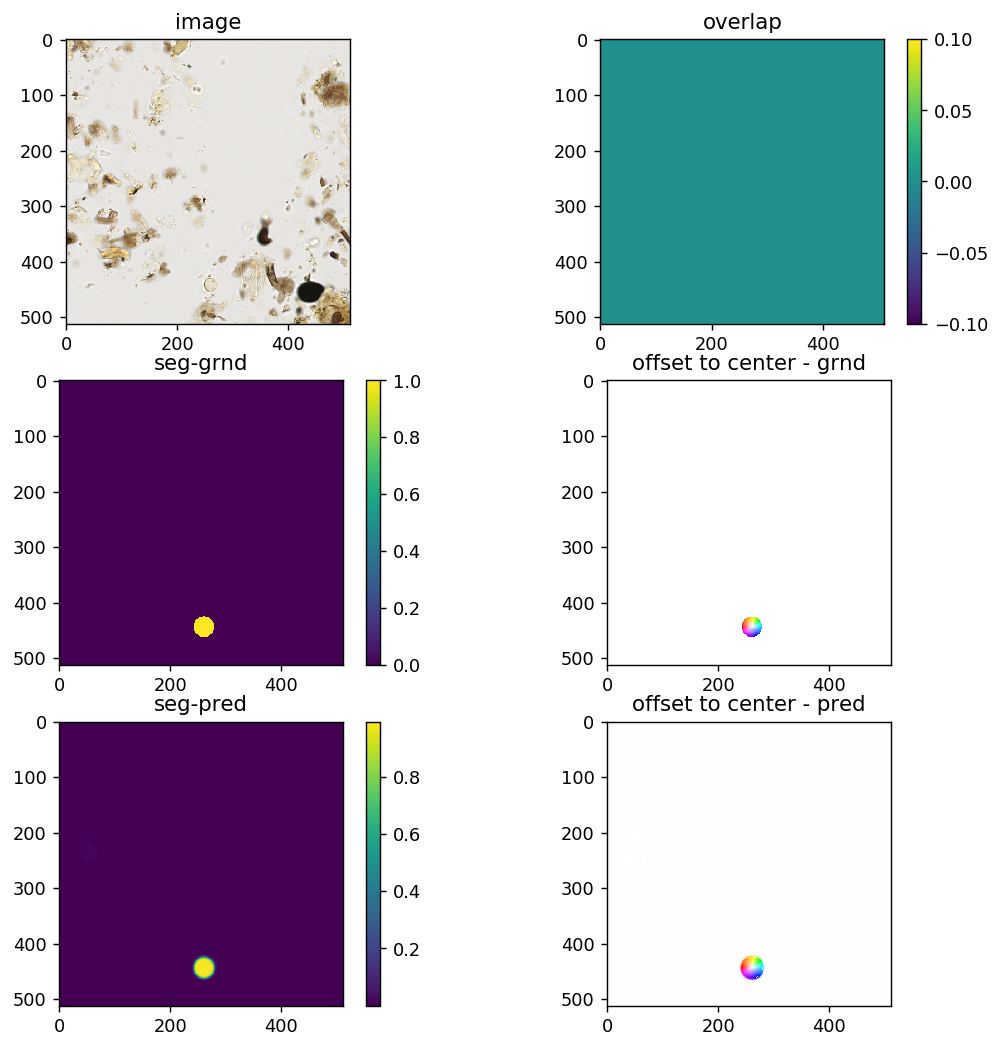

In [8]:
idx = 0

numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 2
plt.figure(figsize=(10, 10), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('image')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_overlap[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('overlap')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = grndSeg[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('seg-grnd')
plt.colorbar()



plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpV = mask_voteX[idx].squeeze().cpu().detach().numpy()
tmpU = mask_voteY[idx].squeeze().cpu().detach().numpy()
flowVisShow = objDemoShowFlow.computeColor(
    tmpV/np.abs(tmpV).max(), 
    tmpU/np.abs(tmpU).max())/255.    
plt.imshow(flowVisShow)
#plt.axis('off')
plt.title('offset to center - grnd')



plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = predSeg[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('seg-pred')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpV = predYXOffset[idx][1].squeeze().cpu().detach().numpy()
tmpU = predYXOffset[idx][0].squeeze().cpu().detach().numpy()
flowVisShow = objDemoShowFlow.computeColor(
    tmpV/np.abs(tmpV).max(), 
    tmpU/np.abs(tmpU).max())/255.    
plt.imshow(flowVisShow)
#plt.axis('off')
plt.title('offset to center - pred')

# visualize

In [9]:
def create_circular_mask(mask, center, radius, value=1):
    h, w = mask.shape[:2]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    tmpMask = dist_from_center <= radius
    mask[tmpMask] = value
    return mask

In [10]:
XtmpV = predYXOffset[idx][1].squeeze().cpu().detach().numpy()
YtmpU = predYXOffset[idx][0].squeeze().cpu().detach().numpy()

predBinaryMask = predSeg[idx].squeeze().cpu().detach().numpy() > 0.5
predBinaryMask = predBinaryMask.astype(np.float32)

XtmpV[predBinaryMask==0] = -3
YtmpU[predBinaryMask==0] = -3

voting4center = np.sqrt(XtmpV*XtmpV + YtmpU*YtmpU)

pred_distanceTransform = ndimage.distance_transform_edt(predBinaryMask)
coord_peaks = feature.peak_local_max(-voting4center, min_distance=5)
#print(coord_peaks)

In [11]:
centerMask = voting4center*0
detMask = voting4center*0
predRadiusList = []
for i in range(coord_peaks.shape[0]):
    y, x = coord_peaks[i]
    #centerMask[y, x] = 1
    centerMask[y-10:y+10, x-10:x+10] = 1
    predRadiusList += [pred_distanceTransform[y,x]]
    detMask = create_circular_mask(detMask, [y, x], pred_distanceTransform[y,x], value=i+1)

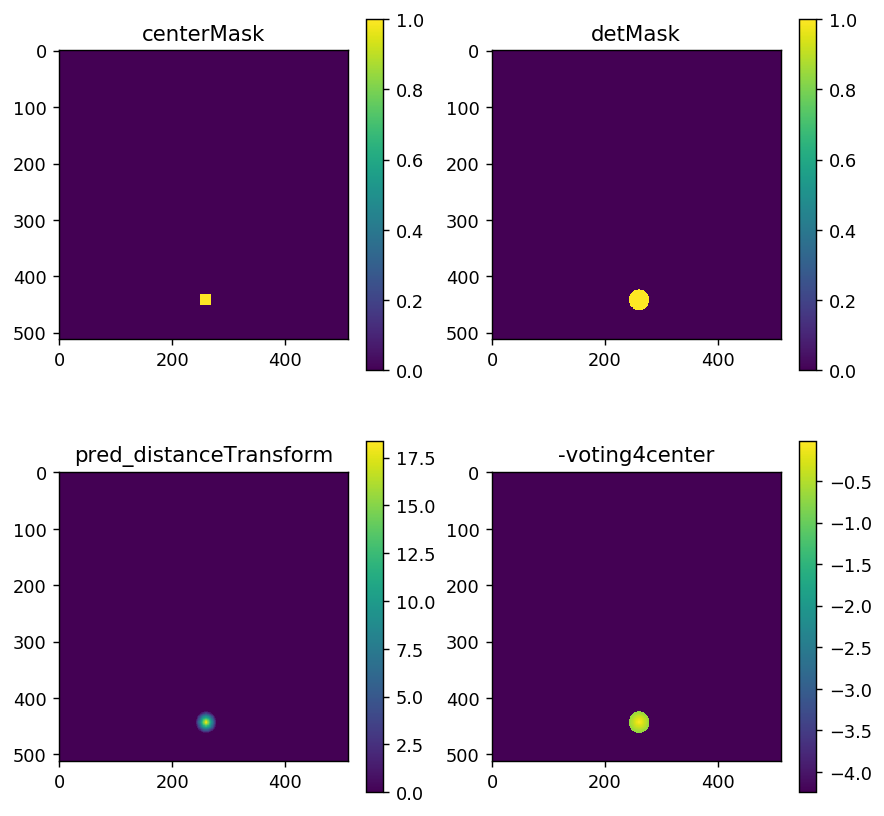

In [12]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(8, 8), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(centerMask)
plt.title('centerMask')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(detMask)
plt.title('detMask')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(pred_distanceTransform)
plt.title('pred_distanceTransform')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(-voting4center)
plt.title('-voting4center')
plt.colorbar()

# evaluation

In [13]:
set_name = 'test'
det_datasets = PollenDet4Eval(path_to_image=path_to_image,
                              path_to_annot=path_to_annotCombo,
                              dbinfo=dbinfo, size=newSize, set_name=set_name)

dataloaders = DataLoader(det_datasets,
                         batch_size=1,
                         shuffle=set_name=='train', 
                         num_workers=4) # num_work can be set to batch_size

In [14]:
iterCount, sampleCount = 0, 0
phase = 'test'
IoUList = []
for sample in dataloaders:
    #print(iterCount)
    
    image, grndSeg, grndDistTransform, mask_overlap, mask_voteX, mask_voteY, mask_peaks, mask_radius, labelOrgSize, mask_peaksOrgSize, mask_distanceTransformOrgSize, mask_radiusOrgSize = sample
    
    #print('A', iterCount)
    
    image = image.to(device)
    grndSeg = grndSeg.to(device) 
    mask_voteX = mask_voteX.to(device)
    mask_voteY = mask_voteY.to(device)
    mask_overlap = mask_overlap.to(device)
    
    #print('B', iterCount)
    
    iterCount += 1
    sampleCount += grndSeg.size(0)   
    if iterCount%50==0:
        print('{}/{}'.format(iterCount,len(det_datasets)))
    
    
    outputs = curmodel(image)
    predSeg = outputs[('segMask', 0)]
    predYXOffset = outputs[('output', 0)]
    
    #print('C', iterCount)
    
    #######################################################
    ##       ground-truth: labelOrgSize, mask_peaksOrgSize
    #######################################################
    tmpGrndList = []
    mask_peaksOrgSize = mask_peaksOrgSize.squeeze().detach().cpu().numpy()
    mask_radiusOrgSize = mask_radiusOrgSize.squeeze().detach().cpu().numpy()
    coord_peaks_OrgSize = feature.peak_local_max(mask_peaksOrgSize, min_distance=5)
    #print('D', coord_peaks_OrgSize.shape[0])
    # mask_radiusOrgSize
    for i in range(coord_peaks_OrgSize.shape[0]):
        y, x = coord_peaks_OrgSize[i]
        r = mask_radiusOrgSize[y, x]
        tmpMask = np.zeros((mask_radiusOrgSize.shape[0], mask_radiusOrgSize.shape[1]), dtype=np.float32)
        tmpMask = create_circular_mask(tmpMask, [y, x], r, value=1)
        tmpGrndList += [tmpMask.copy()]
    
    #print('E', len(tmpGrndList))
    
    ##############################################
    ##          prediction: 
    ##############################################
    tmpPredList = []    
    idx = 0
    predBinaryMask = predSeg > 0.5   
    predBinaryMask = predBinaryMask.type(torch.float)    
    
    predYXOffset_Resize = F.interpolate(predYXOffset,size=(mask_peaksOrgSize.shape[0],mask_peaksOrgSize.shape[1]), mode='bilinear', align_corners=True)
    predBinaryMask_Resize = F.interpolate(predBinaryMask,size=(mask_peaksOrgSize.shape[0],mask_peaksOrgSize.shape[1]), mode='nearest')
    predBinaryMask_Resize = predBinaryMask_Resize.squeeze().cpu().detach().numpy().astype(np.float32)
    XtmpV = predYXOffset_Resize[idx][1].squeeze().cpu().detach().numpy()
    YtmpU = predYXOffset_Resize[idx][0].squeeze().cpu().detach().numpy()
    
    #print('F')
    
    XtmpV[predBinaryMask_Resize==0] = -3
    YtmpU[predBinaryMask_Resize==0] = -3

    voting4center = np.sqrt(XtmpV*XtmpV + YtmpU*YtmpU)
    
    #print('F')
    
    pred_distanceTransform_Resize = ndimage.distance_transform_edt(predBinaryMask_Resize)
    #coord_peaks_Resize = feature.peak_local_max(-voting4center, min_distance=10)
    coord_peaks_Resize = feature.peak_local_max(pred_distanceTransform_Resize, min_distance=5, exclude_border=False)
    
    #print('G', coord_peaks_Resize.shape)
    
    centerMask = voting4center*0
    detMask = voting4center*0
    predRadiusList = []
    tmpPredList = []
    for i in range(coord_peaks_Resize.shape[0]):
        y, x = coord_peaks_Resize[i]
        r = pred_distanceTransform_Resize[y,x]
        tmpMask = np.zeros((predBinaryMask_Resize.shape[0], predBinaryMask_Resize.shape[1]), dtype=np.float32)
        tmpMask = create_circular_mask(tmpMask, [y, x], r, value=1)
        tmpPredList += [tmpMask.copy()]
    
    
    ##############################################
    ####           iterate to match           ####
    ##############################################
    
    #print('\t{} #grnd:{} #pred:{}'.format(iterCount,len(tmpGrndList),len(tmpPredList)))
    #if iterCount == 70:
    #    break
        
    tmpFlagList = [0]  * len(tmpPredList)    
    for elm_grnd in tmpGrndList: 
        tmpIoUList = [-1.0]*len(tmpPredList)
        tmpIoUList = np.asarray(tmpIoUList)
        #print('A')
        for j in range(len(tmpPredList)):
            if tmpFlagList[j]==0:
                elm_pred = tmpPredList[j]
                A = elm_pred + elm_grnd
                A_union = (A>0).astype(np.float32)
                A_union = A_union.sum()
                A_intersection = (A==2).astype(np.float32)
                A_intersection = A_intersection.sum()            
                tmpIoUList[j] = A_intersection / A_union
            #print('B')
        #print('C')
        if len(tmpIoUList)==0:
            maxIoU = 0
        else:
            ind = np.argmax(tmpIoUList)
            maxIoU = np.max(tmpIoUList)
            if maxIoU>0:
                tmpFlagList[ind] = 1
            else:
                maxIoU = 0
        
        IoUList += [maxIoU]
    #print('D')
    #if iterCount==80:
    #    break

50/1218
100/1218
150/1218
200/1218
250/1218
300/1218
350/1218
400/1218
450/1218
500/1218
550/1218
600/1218
650/1218
700/1218
750/1218
800/1218
850/1218
900/1218
950/1218
1000/1218
1050/1218
1100/1218
1150/1218
1200/1218


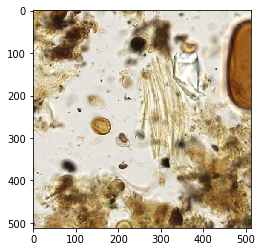

In [17]:
tmpImg = image[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)

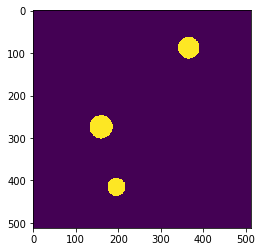

In [18]:
plt.imshow(grndSeg.squeeze().detach().cpu().numpy())

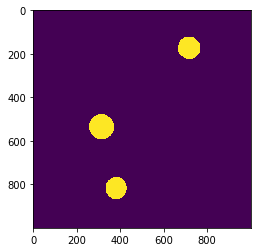

In [19]:
plt.imshow(predBinaryMask_Resize)

In [20]:
voting4center.max(), voting4center.min()

(4.2426405, 0.0060561136)

In [21]:
coord_peaks_Resize = feature.peak_local_max(-voting4center, min_distance=50)

coord_peaks_Resize.shape

(3, 2)

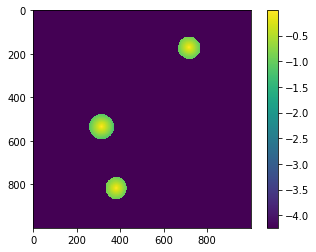

In [22]:
plt.imshow(-voting4center)
plt.colorbar()

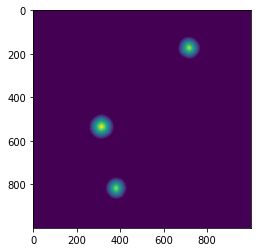

In [23]:
plt.imshow(pred_distanceTransform_Resize)

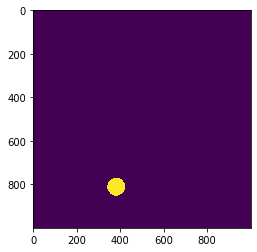

In [26]:
plt.imshow(tmpGrndList[0])

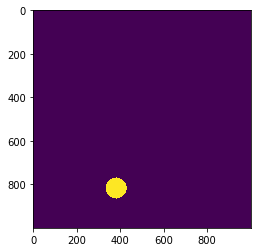

In [27]:
plt.imshow(tmpPredList[0])

In [28]:
result = {}
result['IoUList'] = IoUList

save_to_folder = './result' # experiment directory, used for reading the init model
if not os.path.exists(save_to_folder): 
    os.makedirs(save_to_folder)
save_to_folder = path.join(save_to_folder, project_name+'.pkl')    
    
with open(save_to_folder, 'wb') as handle:
    pickle.dump(result, handle) # , protocol=pickle.HIGHEST_PROTOCOL
    
    
with open(save_to_folder, 'rb') as handle:
    result = pickle.load(handle)

draw curve
-----

In [31]:
iou = np.asarray(result['IoUList'], dtype=np.float32)

In [54]:
recallList = []
iouThreshList = (np.arange(9).astype(np.float32)+1)/10
for i in range(len(iouThreshList)):
    tmp = (iou>iouThreshList[i]).astype(np.float32)
    tmp = tmp.mean()
    recallList += [tmp]
recallList = np.asarray(recallList, dtype=np.float32)

Text(0.5, 1.0, 'seg, center-voting, avgRecall:0.837')

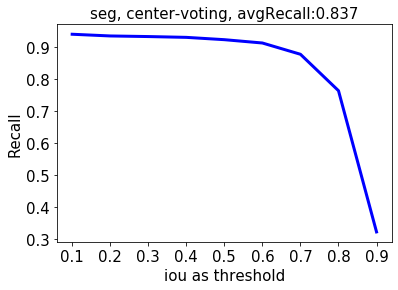

In [58]:
plt.figure()
plt.plot(iouThreshList, recallList, color='blue', linewidth=3, linestyle='-')
plt.xlabel(r'iou as threshold', size=15)
plt.ylabel('Recall', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('seg, center-voting, avgRecall:{:.3f}'.format(recallList.mean()), size=15)



Leaving Blank
-----